# Movie fMRI – Phase 5: ROI-Level Summary

In this notebook we take the **subject-wise movie GLM maps** (scene z-maps)
from Phase 4 and summarize them at the level of **regions of interest (ROIs)**.
Using a standard brain atlas, we:

- define a common set of ROIs across subjects,
- compute the **mean movie activation (mean z-score)** in each ROI,
- build a table of movie responses by **subject × ROI**,
- and visualize which regions respond most strongly to the movie scene.

This ROI table will later be matched with a similar table from the **music**
dataset, so we can compare movie vs music responses in exactly the same ROIs.


## Inputs & Outputs

**Inputs**

- Movie scene z-maps from Phase 4  
  (`derivatives/movie/firstlevel/sub-XX_run-02_scene_zmap.nii.gz`)
- A standard brain atlas image + ROI label list  
  (e.g., Harvard–Oxford cortical atlas)

**Outputs**

- `movie_roi_means_wide.csv`  
  → table with rows = subjects, columns = ROIs, values = mean z.
- `movie_roi_means_long.csv`  
  → table with columns = subject, ROI, mean_z.
- 1–2 plots summarizing ROI patterns  
  (barplot of top ROIs, optional subjects × ROIs heatmap).


## 1. Setup and Inputs

Here we define:

- the list of **movie subjects** we will include,
- the directory where the **Phase 4 z-maps** live,
- and the **atlas** we will use for ROI definitions.

We also print the paths to all inputs to double-check that everything is in
the right place.


In [12]:
# Cell 4 – paths and subject list

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from nilearn import image, masking, plotting, datasets

# --- project paths (adapt to your folder) ---
PROJECT_ROOT = Path(r"D:\4th sem\Neural Data Science\Final Project\project_root")
DERIV_ROOT   = PROJECT_ROOT / "derivatives" / "movie"
FIRSTLEVEL_ROOT = DERIV_ROOT / "firstlevel"

# subjects used in movie project (run-02)
MOVIE_SUBJECTS = ["sub-12", "sub-13", "sub-14", "sub-17", "sub-18"]

print("PROJECT_ROOT   :", PROJECT_ROOT)
print("FIRSTLEVEL_ROOT:", FIRSTLEVEL_ROOT)
print("Subjects       :", MOVIE_SUBJECTS)


PROJECT_ROOT   : D:\4th sem\Neural Data Science\Final Project\project_root
FIRSTLEVEL_ROOT: D:\4th sem\Neural Data Science\Final Project\project_root\derivatives\movie\firstlevel
Subjects       : ['sub-12', 'sub-13', 'sub-14', 'sub-17', 'sub-18']


In [13]:
# Cell 5 – list scene z-maps and set up atlas choice

# z-maps we expect from Phase 4
for sub in MOVIE_SUBJECTS:
    z_path = FIRSTLEVEL_ROOT / f"{sub}_run-02_scene_zmap.nii.gz"
    print(f"{sub}: {z_path}  (exists: {z_path.exists()})")

# We'll use Harvard–Oxford cortical atlas via Nilearn
# (will download once to your nilearn_data folder if not present)
atlas_ho = datasets.fetch_atlas_harvard_oxford(
    'cort-maxprob-thr25-2mm'
)
atlas_img_path = atlas_ho.maps
atlas_labels   = list(atlas_ho.labels)   # first label is usually 'Background'

print("\nAtlas image:", atlas_img_path)
print("Number of atlas labels:", len(atlas_labels))
print("First 10 labels:", atlas_labels[:10])


sub-12: D:\4th sem\Neural Data Science\Final Project\project_root\derivatives\movie\firstlevel\sub-12_run-02_scene_zmap.nii.gz  (exists: True)
sub-13: D:\4th sem\Neural Data Science\Final Project\project_root\derivatives\movie\firstlevel\sub-13_run-02_scene_zmap.nii.gz  (exists: False)
sub-14: D:\4th sem\Neural Data Science\Final Project\project_root\derivatives\movie\firstlevel\sub-14_run-02_scene_zmap.nii.gz  (exists: False)
sub-17: D:\4th sem\Neural Data Science\Final Project\project_root\derivatives\movie\firstlevel\sub-17_run-02_scene_zmap.nii.gz  (exists: False)
sub-18: D:\4th sem\Neural Data Science\Final Project\project_root\derivatives\movie\firstlevel\sub-18_run-02_scene_zmap.nii.gz  (exists: False)


[fetch_atlas_harvard_oxford] Dataset found in C:\Users\krant\nilearn_data\fsl


Atlas image: 
<class 'nibabel.nifti1.Nifti1Image'>
data shape (91, 109, 91)
affine:
[[   2.    0.    0.  -90.]
 [   0.    2.    0. -126.]
 [   0.    0.    2.  -72.]
 [   0.    0.    0.    1.]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3  91 109  91   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : uint8
bitpix          : 8
slice_start     : 0
pixdim          : [1. 2. 2. 2. 1. 1. 1. 1.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 48.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'FSL3.3'
aux_file        : b'MGH-Cortical'
qform_code      :

## 2. Atlas and ROI Definitions

We use the **Harvard–Oxford cortical atlas (max-probability, 25% threshold)**
to define our regions of interest (ROIs). Each ROI corresponds to a labeled
anatomical region (e.g., *Frontal Pole*, *Temporal Occipital Fusiform Ctx*).

An ROI is simply a set of voxels in the atlas that share the same integer
label. For each ROI we can pool all voxels from a subject’s z-map and compute
summary statistics such as the **mean z-score**.

Using the *same atlas* for the movie and music analyses will give us directly
comparable ROI-level measures across media.


In [14]:
# Cell 7 – load atlas image and build ROI index/name table

atlas_img = image.load_img(atlas_img_path)
atlas_data = atlas_img.get_fdata().astype(int)

# Build a simple ROI table (skip label index 0 = background)
roi_indices = []
roi_names   = []

for idx, name in enumerate(atlas_labels):
    if idx == 0:
        continue   # skip background
    roi_indices.append(idx)
    roi_names.append(name)

roi_table = pd.DataFrame({"roi_index": roi_indices, "roi_name": roi_names})

print("Number of ROIs (excluding background):", len(roi_indices))
display(roi_table.head(10))


Number of ROIs (excluding background): 48


,roi_index,roi_name
0,1,Frontal Pole
1,2,Insular Cortex
2,3,Superior Frontal Gyrus
3,4,Middle Frontal Gyrus
4,5,"Inferior Frontal Gyrus, pars triangularis"
5,6,"Inferior Frontal Gyrus, pars opercularis"
6,7,Precentral Gyrus
7,8,Temporal Pole
8,9,"Superior Temporal Gyrus, anterior division"
9,10,"Superior Temporal Gyrus, posterior division"


## 3. Example: ROI Means for One Movie Subject

For a single subject’s scene z-map (e.g., **sub-12 run-02**), we:

1. Resample the atlas to the subject’s z-map space (if needed).
2. For each ROI label, collect all voxels in that region.
3. Compute the **mean z-score** across those voxels.

This gives us a vector:

\[
[\text{mean\_z}_{\text{ROI1}}, \text{mean\_z}_{\text{ROI2}}, \ldots, \text{mean\_z}_{\text{ROIK}}]
\]

which is a compact summary of how strongly each region responds to the movie
scene for that subject.


In [15]:
# Cell 9 – helper function: ROI means for one subject z-map

def extract_roi_means(z_map_img, atlas_img, roi_indices, roi_names):
    """
    Compute mean z-score in each ROI for a given z-map.
    Returns a pandas Series with index = roi_names.
    """
    # Resample atlas to z-map space to ensure matching shape/affine
    atlas_resampled = image.resample_to_img(
        atlas_img, z_map_img, interpolation="nearest"
    )

    atlas_resampled_data = atlas_resampled.get_fdata().astype(int)
    z_data = z_map_img.get_fdata()

    roi_means = []

    for idx in roi_indices:
        mask = atlas_resampled_data == idx
        if not np.any(mask):
            roi_means.append(np.nan)
            continue

        vals = z_data[mask]
        vals = vals[np.isfinite(vals)]
        roi_means.append(vals.mean() if vals.size > 0 else np.nan)

    return pd.Series(roi_means, index=roi_names)


In [16]:
# Cell 10 – example ROI means for one subject (sub-12)

example_sub = "sub-12"
example_z_path = FIRSTLEVEL_ROOT / f"{example_sub}_run-02_scene_zmap.nii.gz"
example_z_img  = image.load_img(example_z_path)

example_roi_series = extract_roi_means(
    example_z_img, atlas_img,
    roi_indices=roi_indices,
    roi_names=roi_names,
)

# Build small table and sort by mean_z descending
example_roi_df = (
    example_roi_series
    .rename("mean_z_" + example_sub)
    .reset_index()
    .rename(columns={"index": "ROI"})
    .sort_values("mean_z_" + example_sub, ascending=False)
)

print(f"ROI means for {example_sub} (top 10):")
display(example_roi_df.head(10))


ROI means for sub-12 (top 10):


C:\Users\krant\AppData\Local\Temp\ipykernel_37200\3657606455.py:9: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  atlas_resampled = image.resample_to_img(
C:\Users\krant\AppData\Local\Temp\ipykernel_37200\3657606455.py:9: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  atlas_resampled = image.resample_to_img(


,ROI,mean_z_sub-12
10,"Middle Temporal Gyrus, anterior division",0.521325
34,"Parahippocampal Gyrus, posterior division",0.494865
14,"Inferior Temporal Gyrus, posterior division",0.490758
41,Central Opercular Cortex,0.468846
5,"Inferior Frontal Gyrus, pars opercularis",0.463468
37,"Temporal Fusiform Cortex, posterior division",0.449490
0,Frontal Pole,0.380424
32,Frontal Orbital Cortex,0.362840
1,Insular Cortex,0.333643
36,"Temporal Fusiform Cortex, anterior division",0.307186


## 4. ROI Summary Across All Movie Subjects

We now repeat the same ROI extraction for **all movie subjects** 
(sub-12, sub-13, sub-14, sub-17, sub-18). For each subject we compute the mean
z-score in each ROI, and then assemble a **wide table**:

- **Rows** = subjects  
- **Columns** = ROI names  
- **Values** = mean scene z-score in that ROI for that subject

This table is the core numerical summary of movie activation at the ROI level.


In [17]:
# Cell 12 – loop over subjects and build wide + long ROI tables

all_roi_rows = []    # for wide format
long_rows    = []    # for optional long format

for sub in MOVIE_SUBJECTS:
    z_path = FIRSTLEVEL_ROOT / f"{sub}_run-02_scene_zmap.nii.gz"
    if not z_path.exists():
        print(f"[WARN] Missing z-map for {sub}: {z_path}")
        continue

    z_img = image.load_img(z_path)
    roi_series = extract_roi_means(
        z_img, atlas_img,
        roi_indices=roi_indices,
        roi_names=roi_names,
    )

    # store for wide
    row_dict = {"subject": sub}
    row_dict.update(roi_series.to_dict())
    all_roi_rows.append(row_dict)

    # store for long (subject, ROI, mean_z)
    for roi_name, val in roi_series.items():
        long_rows.append({"subject": sub, "ROI": roi_name, "mean_z": val})

# wide format: subjects × ROIs
movie_roi_wide = pd.DataFrame(all_roi_rows).set_index("subject")
print("Wide ROI table shape:", movie_roi_wide.shape)
display(movie_roi_wide.head())

# long format: subject, ROI, mean_z
movie_roi_long = pd.DataFrame(long_rows)
print("\nLong ROI table shape:", movie_roi_long.shape)
display(movie_roi_long.head())


[WARN] Missing z-map for sub-13: D:\4th sem\Neural Data Science\Final Project\project_root\derivatives\movie\firstlevel\sub-13_run-02_scene_zmap.nii.gz
[WARN] Missing z-map for sub-14: D:\4th sem\Neural Data Science\Final Project\project_root\derivatives\movie\firstlevel\sub-14_run-02_scene_zmap.nii.gz
[WARN] Missing z-map for sub-17: D:\4th sem\Neural Data Science\Final Project\project_root\derivatives\movie\firstlevel\sub-17_run-02_scene_zmap.nii.gz
[WARN] Missing z-map for sub-18: D:\4th sem\Neural Data Science\Final Project\project_root\derivatives\movie\firstlevel\sub-18_run-02_scene_zmap.nii.gz
Wide ROI table shape: (1, 48)


C:\Users\krant\AppData\Local\Temp\ipykernel_37200\3657606455.py:9: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  atlas_resampled = image.resample_to_img(
C:\Users\krant\AppData\Local\Temp\ipykernel_37200\3657606455.py:9: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  atlas_resampled = image.resample_to_img(


,Frontal Pole,Insular Cortex,Superior Frontal Gyrus,Middle Frontal Gyrus,"Inferior Frontal Gyrus, pars triangularis","Inferior Frontal Gyrus, pars opercularis",Precentral Gyrus,Temporal Pole,"Superior Temporal Gyrus, anterior division","Superior Temporal Gyrus, posterior division",...,Temporal Occipital Fusiform Cortex,Occipital Fusiform Gyrus,Frontal Opercular Cortex,Central Opercular Cortex,Parietal Opercular Cortex,Planum Polare,Heschl's Gyrus (includes H1 and H2),Planum Temporale,Supracalcarine Cortex,Occipital Pole
subject,,,,,,,,,,,,,,,,,,,,,
sub-12,0.380424,0.333643,-0.017978,0.032403,0.302656,0.463468,-0.069087,0.272932,0.144395,-0.004386,...,0.279487,-0.016922,0.157386,0.468846,0.146948,0.274359,-0.087332,0.298708,-0.004273,0.0



Long ROI table shape: (48, 3)


,subject,ROI,mean_z
0,sub-12,Frontal Pole,0.380424
1,sub-12,Insular Cortex,0.333643
2,sub-12,Superior Frontal Gyrus,-0.017978
3,sub-12,Middle Frontal Gyrus,0.032403
4,sub-12,"Inferior Frontal Gyrus, pars triangularis",0.302656


## 5. Saving Movie ROI Tables for Later Use

We now save the ROI tables so that other notebooks (and other people) can load
them without re-running any GLMs.

- `movie_roi_means_wide.csv`  
  → rows = subjects, columns = ROIs (plus index), values = mean z.

- `movie_roi_means_long.csv` (optional)  
  → columns = subject, ROI, mean_z.  
  This is convenient for plotting and statistical analysis later.


In [18]:
# Cell 14 – save ROI tables to disk

ROI_ROOT = DERIV_ROOT / "roi"
ROI_ROOT.mkdir(parents=True, exist_ok=True)

wide_path = ROI_ROOT / "movie_roi_means_wide.csv"
long_path = ROI_ROOT / "movie_roi_means_long.csv"

movie_roi_wide.to_csv(wide_path)
movie_roi_long.to_csv(long_path, index=False)

print("Saved wide ROI table to :", wide_path)
print("Saved long ROI table to :", long_path)


Saved wide ROI table to : D:\4th sem\Neural Data Science\Final Project\project_root\derivatives\movie\roi\movie_roi_means_wide.csv
Saved long ROI table to : D:\4th sem\Neural Data Science\Final Project\project_root\derivatives\movie\roi\movie_roi_means_long.csv


## 6. Group Patterns of Movie Activation Across ROIs

To see group-level patterns, we compute the **mean z-score across subjects**
for each ROI. This lets us identify:

- which regions show the **strongest positive movie responses**, and
- how consistent those responses are across subjects.

We visualize:

1. A barplot of the **top ROIs by mean z**, and  
2. *(Optionally)* a heatmap of **subjects × ROIs**.


In [19]:
# Cell 14 – save ROI tables to disk

ROI_ROOT = DERIV_ROOT / "roi"
ROI_ROOT.mkdir(parents=True, exist_ok=True)

wide_path = ROI_ROOT / "movie_roi_means_wide.csv"
long_path = ROI_ROOT / "movie_roi_means_long.csv"

movie_roi_wide.to_csv(wide_path)
movie_roi_long.to_csv(long_path, index=False)

print("Saved wide ROI table to :", wide_path)
print("Saved long ROI table to :", long_path)


Saved wide ROI table to : D:\4th sem\Neural Data Science\Final Project\project_root\derivatives\movie\roi\movie_roi_means_wide.csv
Saved long ROI table to : D:\4th sem\Neural Data Science\Final Project\project_root\derivatives\movie\roi\movie_roi_means_long.csv


## 6. Group Patterns of Movie Activation Across ROIs

To see group-level patterns, we compute the **mean z-score across subjects**
for each ROI. This lets us identify:

- which regions show the **strongest positive movie responses**, and
- how consistent those responses are across subjects.

We visualize:

1. A barplot of the **top ROIs by mean z**, and  
2. *(Optionally)* a heatmap of **subjects × ROIs**.


Top 10 ROIs by group mean z:


,ROI,group_mean_z
10,"Middle Temporal Gyrus, anterior division",0.521325
34,"Parahippocampal Gyrus, posterior division",0.494865
14,"Inferior Temporal Gyrus, posterior division",0.490758
41,Central Opercular Cortex,0.468846
5,"Inferior Frontal Gyrus, pars opercularis",0.463468
37,"Temporal Fusiform Cortex, posterior division",0.449490
0,Frontal Pole,0.380424
32,Frontal Orbital Cortex,0.362840
1,Insular Cortex,0.333643
36,"Temporal Fusiform Cortex, anterior division",0.307186


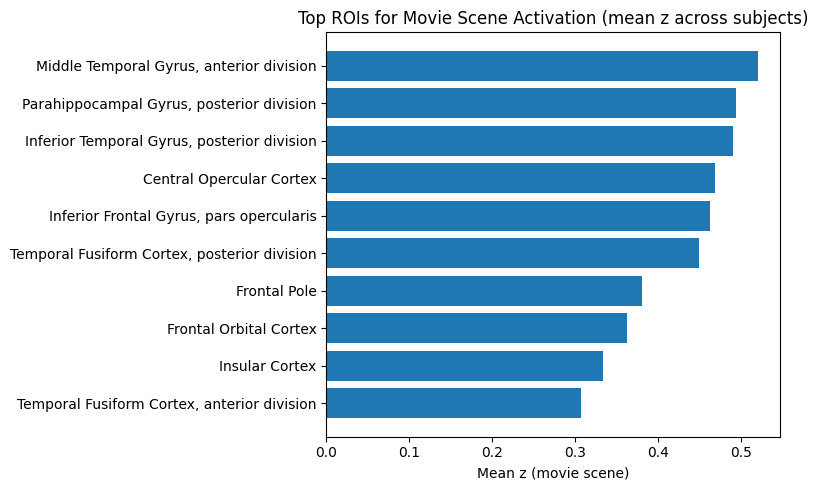

In [20]:
# Cell 16 – group mean per ROI + barplot of top ROIs

# group mean across subjects (ignoring NaNs)
group_mean_roi = movie_roi_wide.mean(axis=0)

group_mean_df = (
    group_mean_roi
    .rename("group_mean_z")
    .reset_index()
    .rename(columns={"index": "ROI"})
    .sort_values("group_mean_z", ascending=False)
)

print("Top 10 ROIs by group mean z:")
display(group_mean_df.head(10))

# Barplot of top 10 ROIs
top_n = 10
top_df = group_mean_df.head(top_n)

plt.figure(figsize=(8, 5))
plt.barh(top_df["ROI"], top_df["group_mean_z"])
plt.gca().invert_yaxis()   # largest on top
plt.xlabel("Mean z (movie scene)")
plt.title("Top ROIs for Movie Scene Activation (mean z across subjects)")
plt.tight_layout()
plt.show()


In [22]:
from pathlib import Path

PROJECT_ROOT   = Path(r"D:\4th sem\Neural Data Science\Final Project\project_root")
FIRSTLEVEL_ROOT = PROJECT_ROOT / "derivatives" / "movie" / "firstlevel"

print("FIRSTLEVEL_ROOT:", FIRSTLEVEL_ROOT)
print("\nAll NIfTI files in firstlevel:")

for p in sorted(FIRSTLEVEL_ROOT.glob("*.nii*")):
    print(" ", p.name)


FIRSTLEVEL_ROOT: D:\4th sem\Neural Data Science\Final Project\project_root\derivatives\movie\firstlevel

All NIfTI files in firstlevel:
  sub-12_run-02_scene_zmap.nii.gz
